# Goal

 Submissions are evaluated by root mean squared error (RMSE). True target values are clipped into [0,20] range.

# Data

数据文件和数据的说明

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

1. sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
2. test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
3. sample_submission.csv - a sample submission file in the correct format.
4. items.csv - supplemental information about the items/products.
5. item_categories.csv  - supplemental information about the items categories.
6. shops.csv- supplemental information about the shops.

# Data fields

1. ID - an Id that represents a (Shop, Item) tuple within the test set
2. shop_id - unique identifier of a shop
3. item_id - unique identifier of a product
4. item_category_id - unique identifier of item category
5. item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
6. item_price - current price of an item
7. date - date in format dd/mm/yyyy
8. date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 9. 1,..., October 2015 is 33
10. item_name - name of item
11. shop_name - name of shop
12. item_category_name - name of item category

# 观测数据

## 导包

In [2]:
import numpy as np
import pandas as pd
import pandas_profiling  as ppf

from sklearn.externals import joblib##模型的保存
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')  # 关闭警告模块

### 训练集、测试集

In [3]:
train = pd.read_csv('./DATA/sales_train_v2.csv')
test = pd.read_csv('./DATA/test.csv')

In [4]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [6]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
ID         214200 non-null int64
shop_id    214200 non-null int64
item_id    214200 non-null int64
dtypes: int64(3)
memory usage: 4.9 MB


### 查看异常值，可视化

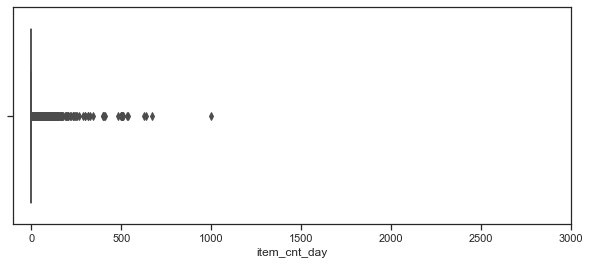

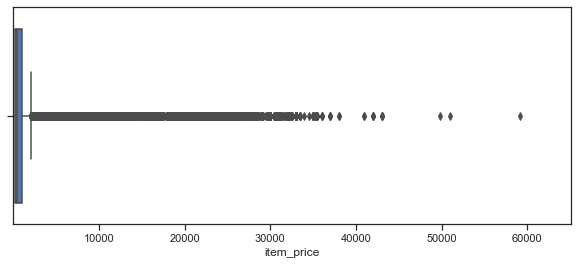

In [38]:
%matplotlib inline
plt.figure(figsize=(10,4))#图的大小
plt.xlim(-100, 3000)#范围
sns.boxplot(x=train.item_cnt_day)#自变量
plt.show()
plt.figure(figsize=(10,4))#图的大小
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)#最大值乘以1.1
sns.boxplot(x=train.item_price)#自变量
plt.show()

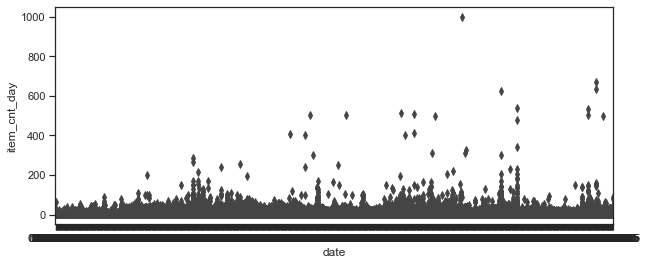

In [41]:
plt.figure(figsize=(10,4))#图的大小
sns.set(style="ticks")
sns.boxplot(x=train.date,y=train.item_cnt_day)#自变量
plt.show()

### 根据图像，删除异常值

train = train[train.item_cnt_day<400] 这里可以考虑1000，400和200

In [42]:
##先对每日销售的产品数量进行修改
train = train[train.item_cnt_day<400] ##这里可以考虑1000，400和200
train = train[train.item_cnt_day>0]
##再对产品的销售价格进行修改
train = train[train.item_price<250000]
train = train[train.item_price>1]

# 数据重做 — 聚焦于item_cnt_month

对日期变换

In [44]:
train['date']= pd.to_datetime(train['date'], format='%d.%m.%Y')##官网进行查询

In [50]:
train['date'].head()

0   2013-01-02
1   2013-01-03
3   2013-01-06
4   2013-01-15
5   2013-01-10
Name: date, dtype: datetime64[ns]

In [48]:
%%time
# 将数据转换为月度销售数据

# 制作仅包含月度销售数据的数据集
data = train.groupby([train['date'].apply(lambda x: x.strftime('%Y-%m')),'item_id','shop_id']).sum().reset_index()
##https://blog.csdn.net/Leonis_v/article/details/51832916--关于groupby的解释
##https://www.runoob.com/python/att-time-strftime.html--关于strftime的解释
# data.head()
# 指定我们要添加到数据的重要属性
data = data[['date','item_id','shop_id','item_cnt_day']]

# 最后，我们可以从数据集中选择重要的特定属性
data = data.pivot_table(index=['item_id','shop_id'], columns = 'date', values = 'item_cnt_day', fill_value = 0).reset_index()
##https://zhuanlan.zhihu.com/p/31952948--关于pivot_table的解释

print (data.shape)
print (data.head())#目的是把每一个月的放到一起

(423680, 36)
date  item_id  shop_id  2013-01  2013-02  2013-03  2013-04  2013-05  2013-06  \
0           0       54        0        0        0        0        0        0   
1           1       55        0        0        0        0        0        0   
2           2       54        0        0        0        0        0        0   
3           3       54        0        0        0        0        0        0   
4           4       54        0        0        0        0        0        0   

date  2013-07  2013-08  ...  2015-01  2015-02  2015-03  2015-04  2015-05  \
0           0        0  ...        0        0        0        0        0   
1           0        0  ...        0        0        0        0        0   
2           0        0  ...        0        0        0        0        0   
3           0        0  ...        0        0        0        0        0   
4           0        0  ...        0        0        0        0        0   

date  2015-06  2015-07  2015-08  2015-09  2015-10

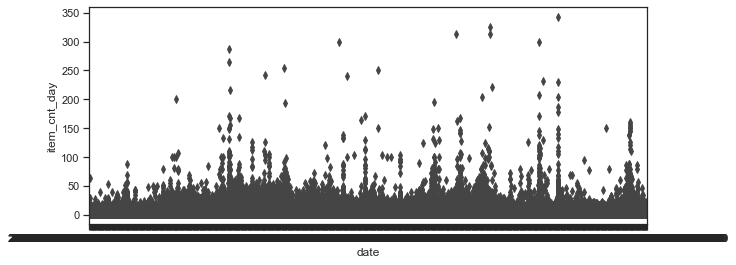

In [51]:
plt.figure(figsize=(10,4))#图的大小
sns.set(style="ticks")
sns.boxplot(x=train.date,y=train.item_cnt_day)#自变量
plt.show()

In [52]:
test.head()#训练集和测试集变成一样就好了

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [53]:
##将数据进行组合
test = pd.merge(test, data, on = ['item_id', 'shop_id'], how = 'left')
##https://blog.csdn.net/weixin_37226516/article/details/64137043--merge的说明

# 将空值填充为0
test.fillna(0, inplace = True)

# 看一下这个数据集
test.head()

,ID,shop_id,item_id,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 创建实际的数据集

In [54]:
# 现在让我们创建实际的训练数据

x_train = test.drop(['2015-10', 'item_id', 'shop_id'], axis = 1)##和咱们提交格式有关
y_train = test['2015-10']

# 删除第一列，以便它可以预测未来的销售数据
x_test = test.drop(['2013-01', 'item_id', 'shop_id'], axis = 1)#保持和训练集一样的特征数

# 检查一下数据的维度看对不对
print("Shape of x_train :", x_train.shape)
print("Shape of x_test :", x_test.shape)
print("Shape of y_train :", y_train.shape)

Shape of x_train : (214200, 34)
Shape of x_test : (214200, 34)
Shape of y_train : (214200,)


# 模型的构建

In [56]:
%%time

# 用GradientBoostingRegressor进行预测
from sklearn.ensemble import GradientBoostingRegressor
GBR = GradientBoostingRegressor()
GBR.fit(x_train, y_train)
mode2 = GBR.predict(x_test).clip(0,20)##把预测之后的值限定在0到20之间
joblib.dump(GBR, 'GBR2.pkl')##模型的保存

Wall time: 27.6 s


['GBR2.pkl']

In [58]:
mode2=pd.DataFrame(mode2,columns=['item_cnt_month'])

In [60]:
mode2.head()

,item_cnt_month
0,0.563260
1,0.254246
2,0.789354
3,0.291173
4,0.254246


In [61]:
mode2.to_csv('submission.csv',index_label='ID')